# Sampling from the version space

Let's consider a simple example where we have access to the true rules that generated the data. We can build a dataset that is generated by these rules and then build the version space, that is, a set of all possible rules that could have generated the data. We can then sample from this version space with different techniques and see how classification performance changes.

We consider the following ground truth rule set (i.e., a DNF).

$$x_0=0 \wedge x_1=1 \vee x_2=1$$

We consider as hypothesis space the set of m-terms k-DNF, that is, all possible combinations **up to** $k$ different conjunctive rules put in OR, where each rule is a conjunction of **at most** $m$ features.

For example, the chosen DNF is a 2-term 2-DNF. Instead, a 3-term 2-DNF could be $x_0=0 \wedge x_1=1 \wedge x_3=1 \vee x_2=1$.

The hypothesis space chosen is a 3-term 3-DNF. This means that we can have rules like $x_0=0 \wedge x_1=1 \wedge x_3=1 \vee x_2=1 \vee x_4=0$. While it may seem like it's small, it's actually quite big. For 8 features, we have 31,850,976 possible DNFs.

In [1]:
import math

from tqdm import tqdm

from bpllib.rules._discrete_constraint import DiscreteConstraint
from bpllib.rules._rule import Rule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# random rules
r1 = Rule(constraints={0: DiscreteConstraint(value=0, index=0),
                       1: DiscreteConstraint(value=1, index=1),
                       #3: DiscreteConstraint(value=0, index=3)
                       })

r2 = Rule(constraints={2: DiscreteConstraint(value=1, index=2),
                       #4: DiscreteConstraint(value=1, index=4)
                       }
          )

# r3 = Rule(constraints={5: DiscreteConstraint(value=1, index=5),
#                       6: DiscreteConstraint(value=0, index=6)})

rule_set = [r1, r2]


576


provare ad usare 4-5 features nella regola, e.g., 3 or, e vediamo se effettivamente...

## Generate data

We generate a dataset of 100 samples for the train set and the test set. We use the same rules to generate the labels for both sets.

Each datapoint is in $\{0, 1\}^8$. The rules involve only the first three features, hence rules in the version space may have spurious features inside.

All the possible conjunctive rules involving 8 features and 3 terms are 576. IDEA TO IMPLEMENT: we can already filter out the ones that cover any negative example. Of course, they will not be in the version space. We can't remove rules that don't cover any positive example, because they can still be in the version space.

In [82]:
# sarebbe utile provare con più ripetizioni degli split random.
# vado a generarmi tutte le combinazioni e faccio uno split train test.
X_train = np.random.randint(0, 2, size=(100, 8))
y_train = np.array([any([r.covers(x) for r in rule_set]) for x in X_train])
X_test = np.random.randint(0, 2, size=(100, 8))
y_test = np.array([any([r.covers(x) for r in rule_set]) for x in X_test])

y_train.sum()

import itertools


def generate_rules(m, n_features=7):
    all_features = list(range(n_features))
    combos = itertools.combinations(all_features, m)
    rules = set()
    for combo in combos:
        for combo_values in itertools.product([0, 1], repeat=m):
            rule = Rule(constraints={})
            for i in range(m):
                if combo_values[i] == 0:
                    rule.constraints[combo[i]] = DiscreteConstraint(value=0, index=combo[i])
                else:
                    rule.constraints[combo[i]] = DiscreteConstraint(value=1, index=combo[i])
            rules.add(rule)
    return rules


rules_space = set.union(*[generate_rules(m=m, n_features=8) for m in range(1, 4)])
print(len(rules_space))



576


powerset -> 2**d numero di congiunzioni possibili su d features.
se ne vuoi considerare al massimo m, $$\sum_{i=1}^m C(d,i) = \sum_{i=1}^m \frac{d!}{(d-i)!i!}$$

$$\sum_{m=0}^n ... = 2 ** n

C(n,m)


n + n*(n-1) + n*(n-1)*(n-2) + ... n*(n-1)*...+(n-m+1)

C(n,1) + C(n,2) + ... C(n,m)

numero di conigunzioni lunghezza al più m considerando n features (quella vuota non vale).

$$N_m$$

con una dnf di dimensione k (esattamente)
$$C(N_m, k)$$

Con al più k, allora segui quello sopra.

In [2]:
def generate_tuples_async(k):
    for i in range(1, k + 1):
        tuples = itertools.combinations(rules_space, i)

        for t in tuples:
            yield t

In [3]:
# takes 5 minutes

VS = set()

from tqdm import tqdm
for h in tqdm(generate_tuples_async(3), total=math.comb(len(rules_space), 3)):
    ok = True
    for x in X_train[y_train==1]:
        if not any([r.covers(x) for r in h]):
            ok = False
            break
    for x in X_train[y_train==0]:
        if any([r.covers(x) for r in h]):
            ok = False
            break
    if ok:
        VS.add(h)

31850976it [04:46, 111126.43it/s]                              


In [4]:
len(VS)  # should be 246

246

Here we can see the rules found. The shortest rule is the correct one (the one that generated the data),

(X[2] == 1, X[0] == 0 ^ X[1] == 1)

But we can also find many other different, valid DNFs.

è più improbabile che una dnf corta sia buona sul training set.
importante dare priorità a quelle corte.

se hai una serie di esempi e prendi ruleset di complessità crescente, il tuo vs è composto da maggior parte regole complesse. poche regole semplici che soddisfano (che sono in vs).

una regola semplice ha molta meno prob di entrare in vs. a priori. se ci entra, essendo meno probabile a priori, allora è più probabile che...

potrebbe esserci anche un rs più corto, per questo dovremmo comunque guardare anche quelle più difficili...

In [87]:
sorted(VS, key=len)[:20]

[(X[2] == 1, X[0] == 0 ^ X[1] == 1),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0, X[2] == 1),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[2] == 1,
  X[0] == 0 ^ X[2] == 1 ^ X[7] == 0),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[2] == 1 ^ X[4] == 1,
  X[2] == 1 ^ X[4] == 0),
 (X[2] == 1, X[0] == 1 ^ X[1] == 0 ^ X[2] == 1, X[0] == 0 ^ X[1] == 1),
 (X[1] == 0 ^ X[2] == 1, X[2] == 1, X[0] == 0 ^ X[1] == 1),
 (X[2] == 1 ^ X[3] == 1 ^ X[7] == 1, X[2] == 1, X[0] == 0 ^ X[1] == 1),
 (X[2] == 1, X[0] == 0 ^ X[1] == 1, X[2] == 1 ^ X[6] == 1),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[2] == 1,
  X[0] == 1 ^ X[2] == 1 ^ X[3] == 0),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[2] == 1,
  X[2] == 1 ^ X[4] == 0 ^ X[6] == 0),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0, X[2] == 1, X[2] == 1 ^ X[7] == 0),
 (X[2] == 1, X[0] == 0 ^ X[1] == 1, X[2] == 1 ^ X[3] == 1 ^ X[5] == 1),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[2] == 1,
  X[2] == 1 ^ X[5] == 0 ^ X[6] == 0),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[2] == 1,
  X[2] == 1 ^ X[

## Uniform and weighted sampling

Here we implement the uniform sampling from the version space. We also implement the weighted sampling, where the probability of a ruleset is proportional to the length of the ruleset, i.e., the number of ORs.

To estimate correctly the performance of the sampling, we repeat the sampling 10000 times and compute the mean and the standard deviation of the accuracy on the test dataset.

In [85]:
import random
from sklearn.metrics import accuracy_score

def uniform_bp(T=3, iters=10000, return_sample=False):
    accuracies = []
    for i in range(iters):
        # sample from VS
        uniform_sample = random.choices(list(VS), k=T)
        y_pred = np.array([sum([any([r.covers(x) for r in h]) for h in uniform_sample]) >= T // 2 for x in X_test])

        acc = accuracy_score(y_pred, y_test)
        accuracies.append(acc)
    print("(beta={}, unif) {} +- {} (N={})".format(0, np.mean(accuracies), np.std(accuracies), iters))
    if return_sample:
        return uniform_sample
    return np.mean(accuracies), np.std(accuracies)

In [83]:
def weighted_bp(T=3, beta=10, iters=10000, return_sample=False):
    accuracies = []
    for i in range(iters):
        p = np.array([np.exp(-beta * len(h)) for h in VS])
        p = p / sum(p)
        weighted_sample = random.choices(list(VS), k=T, weights=p)
        y_pred = np.array([sum([any([r.covers(x) for r in h]) for h in weighted_sample]) >= T // 2 for x in X_test])

        acc = accuracy_score(y_pred, y_test)
        accuracies.append(acc)
    print("(beta={}) {} +- {} (N={})".format(beta, np.mean(accuracies), np.std(accuracies), iters))
    if return_sample:
        return weighted_sample
    return np.mean(accuracies), np.std(accuracies)

Using uniform sampling, we can see many spurious rules.

246 dnf
nella versione uniform, calcoli per ogni dnf +1/-1 sul test per ogni esempio.

In [86]:
uniform_bp(T=3, return_sample=True)

(beta=0, unif) 0.9975639999999999 +- 0.010830785013100398 (N=10000)


[(X[2] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 1),
 (X[0] == 0 ^ X[1] == 1 ^ X[6] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[2] == 1),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[2] == 1,
  X[2] == 1 ^ X[3] == 0 ^ X[7] == 1)]

Using weighted sampling, we get a much better result.

In [84]:
weighted_bp(T=3, return_sample=True)

(beta=10) 0.9999899999999999 +- 0.0007070360669725421 (N=10000)


[(X[2] == 1, X[0] == 0 ^ X[1] == 1),
 (X[2] == 1, X[0] == 0 ^ X[1] == 1),
 (X[0] == 0 ^ X[1] == 1 ^ X[2] == 0, X[2] == 1)]

The results confirm our hypothesis. Using the uniform sampling we already get really good results, but they are further improved by using the weighted sampling.

(beta=0, unif) 0.9985 +- 0.008529361054615995 (N=1000)
(beta=0, unif) 0.99802 +- 0.010113337727970927 (N=1000)
(beta=0, unif) 0.99998 +- 0.000446766158073774 (N=1000)
(beta=0, unif) 0.99997 +- 0.0005469003565550131 (N=1000)
(beta=5) 0.9991500000000001 +- 0.00646355165524343 (N=1000)
(beta=5) 0.9991 +- 0.006647555941848108 (N=1000)
(beta=5) 1.0 +- 0.0 (N=1000)
(beta=5) 1.0 +- 0.0 (N=1000)


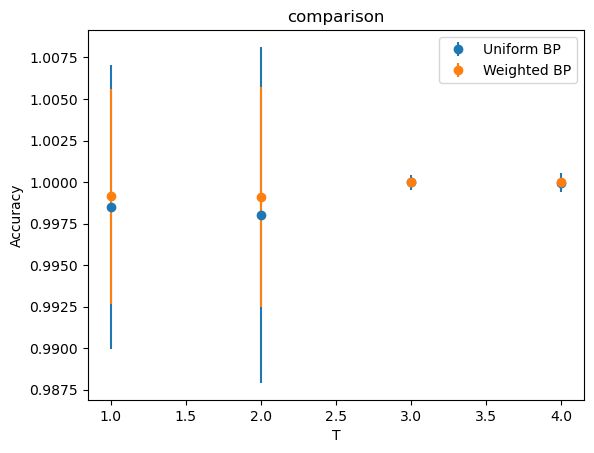

In [91]:
# create a plot with std error bars

import matplotlib.pyplot as plt

def plot_results(results, title):
    means = [r[0] for r in results]
    stds = [r[1] for r in results]
    plt.errorbar(range(1, len(means) + 1), np.array(means), yerr=stds, fmt='o', label=title)

# set y scale to log
# plt.yscale('log')
plot_results([uniform_bp(t, iters=1000) for t in range(2, 6)], "Uniform BP")
plot_results([weighted_bp(t, iters=1000, beta=5) for t in range(2, 6)], "Weighted BP")
plt.title('comparison')
plt.xlabel("T")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


D1 = [...]
D2 = D1 or x3=0
D3 = D1 or x3=1

guarda cambiando il numero di esempi. con pochi esempi cosa succede?

quando hai più esempi di training, puoi usare un beta più grande.
quando hai pochi esempi, beta più piccolo è meglio.